In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io,transform
from torchvision import transforms,utils
import numpy as np
import torch
import random

def gen_rand_trans():
    rand_sign= 1 if random.random() < 0.5 else -1
    return random.randint(0,20)*rand_sign

def gen_transformation_matrix(tx,ty,tz):
    return[[1,0,1,tx], [0,1,0,ty],[1,0,1,tz],[0,0,0,1]]

train_data1=np.load('MDS663_Cluster_Training_Data.npy')
train_label_vector1=np.load('MDS663_Cluster_Training_Labels.npy')

train_data2=np.load('MDS669_Cluster_Training_Data.npy')
train_label_vector2=np.load('MDS669_Cluster_Training_Labels.npy')

training_data=np.concatenate([train_data1,train_data2],axis=0)
training_label_vector=np.concatenate([train_label_vector1,train_label_vector2],axis=0)



test_data=np.load('MDS1006_Cluster_Training_Data.npy')
test_label_vector=np.load('MDS1006_Cluster_Labels.npy')


class FeatherPointClass(Dataset):
    def __init__(self, training_data,labels, datatype, transform = transforms.Compose([transforms.ToTensor()])):
        self.datatype = datatype
        self.data=training_data

        if self.datatype == 'train':
            self.labels=labels
        self.transform = transform
        
        if self.datatype == 'test':
            self.labels=labels

            

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            return self.data[idx,:,:],self.labels[idx]

        if self.datatype == 'test':
            return self.data[idx,:,:],self.labels[idx]

        
class STN3D(torch.nn.Module):
    def __init__(self):
        super(STN3D,self).__init__()

        self.conv1 = torch.nn.Conv1d(3, 128, 1)
        self.conv2 = torch.nn.Conv1d(128, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 1024, 1)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.fc4 = torch.nn.Linear(128,64)
        self.fc5 = torch.nn.Linear(64,32)
        self.fc6 = torch.nn.Linear(32,1)

        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.bn3 = torch.nn.BatchNorm1d(1024)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.bn5 = torch.nn.BatchNorm1d(256)
        self.relu=torch.nn.LeakyReLU()


    def forward(self, x):
        batchsize = x.size()[0]
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = self.relu(self.bn4(self.fc1(x)))
        x = self.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        x=self.relu(x)
        x=self.fc4(x)
        x=self.relu(x)
        x=self.fc5(x)
        x=self.relu(x)
        x=self.fc6(x)

        return x
feather_test_class=FeatherPointClass(training_data=test_data,datatype='test',labels=test_label_vector)
test_loader=torch.utils.data.DataLoader(feather_test_class,batch_size=10,num_workers=1,shuffle=True)

conv_feather_model=STN3D()
feather_train_class=FeatherPointClass(training_data=training_data,datatype='train',labels=training_label_vector)
train_loader = torch.utils.data.DataLoader(feather_train_class, batch_size=10, sampler=None,shuffle=True, num_workers=1)
criterion=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(conv_feather_model.parameters(),lr=.00000005)#lr=0.00001 batch_size=300
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=0.1)

In [2]:
loss=0
loss_record=[]
test_loss=[]
conv_feather_model=conv_feather_model.cuda()
for epoch in range(700):
    losses=[]

    for batch_i,(data_set,label) in enumerate(train_loader):
        optimizer.zero_grad()
        z=data_set.float()
        z=z.cuda()
        out=conv_feather_model(z)
        label=label.cuda()
        loss=criterion(torch.squeeze(out),label.float())
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.numpy())
    loss_record.append(np.mean(losses))
    
    #Now test the model#
    with torch.no_grad():
        losses=[]
        conv_feather_model.eval()
        for batch_i,(point_vector,label) in enumerate(test_loader):
            z=point_vector.float()
            label=label.cuda()
            z=z.cuda()
            out=conv_feather_model(torch.squeeze(z))
            loss=criterion(torch.squeeze(out),label.float())
            losses.append(loss.cpu().data.numpy())
        test_loss.append(np.mean(losses))
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

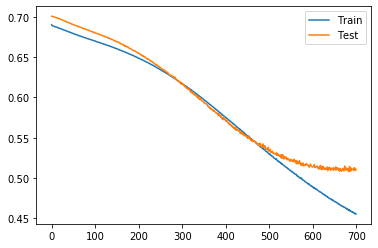

In [4]:
import matplotlib.pyplot as plt
plt.plot(loss_record,label='Train')
plt.plot(test_loss,label='Test')
plt.legend() 
plt.show()

In [5]:
torch.save(conv_feather_model,'conv_feather_model_ordered')

/home/tylerthompson/miniconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type STN3D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [205]:
#I want to visualize the results#
#first, load in the base data#
#now I want to read that in to make sure I can access it#
#**********ACtually not yet, use the actual data first***************#
# with open("MDS669_Clusters_And_Labels.txt",'r') as f:
#     content=f.readlines()

to_be_labeled_clusters=np.load('MDS1006_Eval_Data.npy')
eval_data=to_be_labeled_clusters

class FeatherPointClass(Dataset):
    def __init__(self, training_data,labels, datatype, transform = transforms.Compose([transforms.ToTensor()])):
        self.datatype = datatype
        self.data=training_data

        if self.datatype == 'train':
            self.labels=labels
        self.transform = transform
        
        if self.datatype == 'test':
            self.labels=labels

            

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            return self.data[idx,:,:],self.labels[idx]

        if self.datatype == 'test':
            return self.data[idx,:,:],self.labels[idx]

num_training_pts=np.shape(eval_data)[0]
label_vector=np.ones(np.shape(eval_data)[0])
feather_train_class=FeatherPointClass(training_data=eval_data,datatype='train',labels=label_vector)
train_loader = torch.utils.data.DataLoader(feather_train_class, batch_size=5000, sampler=None,shuffle=False, num_workers=1)
print(num_training_pts)
sig_layer=torch.nn.Sigmoid()
predictions=[]
for batch_i,(point_vector,label) in enumerate(train_loader):
    conv_feather_model.eval()
    z=point_vector.float()
    z=z.cuda()
    out=conv_feather_model(torch.squeeze(z))
    out=sig_layer(out)
    predictions.append(out.tolist())
    
# now convert the predictions to numpy#
flat_predictions = []
for sublist in predictions:
    for item in sublist:
        flat_predictions.append(item)
pos_xs=[]
pos_ys=[]
pos_zs=[]
neg_xs=[]
neg_ys=[]
neg_zs=[]
cluster_labels=[]
for kk in range(len(flat_predictions)):
    if flat_predictions[kk][0]<.55:
        neg_xs.append(eval_data[kk,0,:])
        neg_ys.append(eval_data[kk,1,:])
        neg_zs.append(eval_data[kk,2,:])
    if flat_predictions[kk][0]>.55:
        cluster_labels.append(kk)
        pos_xs.append(eval_data[kk,0,:])
        pos_ys.append(eval_data[kk,1,:])
        pos_zs.append(eval_data[kk,2,:])
    
    
    






1023


In [207]:
np.shape(to_be_labeled_clusters)

(1023, 3, 50)

In [124]:
import mayavi
from mayavi import mlab
mlab.points3d(pos_xs,pos_ys,pos_zs,color=(0,1,0),scale_factor=0.1)
mlab.points3d(neg_xs,neg_ys,neg_zs,color=(1,0,0),scale_factor=0.1)

mlab.show()

In [10]:
#now I want to read that in to make sure I can access it#
with open("MDS663_Clusters_And_Labels.txt",'r') as f:
    content=f.readlines()
def content_index_point_counter(content_string):
    split_line=content_string.split(' ')
    label=int(split_line[0][1])


    #get_xs ys and zs for one of the clusters#
    xs=[]
    ys=[]
    zs=[]

    xyz_counter=0
    for kk in range(len(split_line)-1):
        single_line=','.join(split_line[kk+1]).replace(',','')
        if xyz_counter==0:
            xs.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==1:
            ys.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==2:
            zs.append(float(single_line[0:10].replace('[','')))
        if single_line[-1]==']':
            xyz_counter=xyz_counter+1
    #Now, I would really like to order the data#
    full_cluster=np.zeros([3,len(xs)])
    full_cluster[0,:]=xs
    full_cluster[1,:]=ys
    full_cluster[2,:]=zs
    return len(xs),full_cluster


initial_cluster_matrix=np.zeros([3,1])
sufficient_indices=[]
for kk in range(len(content)):
    num_points,cluster_matrix=content_index_point_counter(content[kk])
    if num_points>50:
        sufficient_indices.append(kk)
def extract_compressed_coordinates(content_string):
    split_line=content_string.split(' ')
    label=int(split_line[0][1])


    #get_xs ys and zs for one of the clusters#
    xs=[]
    ys=[]
    zs=[]

    xyz_counter=0
    for kk in range(len(split_line)-1):
        single_line=','.join(split_line[kk+1]).replace(',','')
        if xyz_counter==0:
            xs.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==1:
            ys.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==2:
            zs.append(float(single_line[0:10].replace('[','')))
        if single_line[-1]==']':
            xyz_counter=xyz_counter+1
    #Now, I would really like to order the data#
    full_cluster=np.zeros([3,len(xs)])
    full_cluster[0,:]=xs
    full_cluster[1,:]=ys
    full_cluster[2,:]=zs
    if len(xs)<51:
        condensed_xs=[-1]*50
        condensed_ys=[-1]*50
        condensed_zs=[-1]*50
        label=-1
    else:



        import scipy
        ordered_cluster_data=np.zeros(np.shape(full_cluster))
        unordered_array=full_cluster
        ##create the tree from those#
        ordered_array=np.zeros([3,len(xs)])
        feather_tree=scipy.spatial.KDTree(unordered_array.transpose())

           #pick a random point in the feather set#
        neighbors=feather_tree.query(unordered_array[:,3],k=len(xs))

            #presumably, this will be one of the ends of the feathrs if it's a feather#
        furthest_point1=unordered_array[:,neighbors[1][len(xs)-1]]

             #do it again#
        neighbors=feather_tree.query(furthest_point1,k=len(xs))
        furthest_point2=unordered_array[:,neighbors[1][len(xs)-1]]

        #now start at one, then go to the other#
        for kk in range(len(neighbors[1])):
            ordered_cluster_data[:,kk]=unordered_array[:,neighbors[1][kk]]

        #now average the sections of ordered data to generate 50 points#
        n=int(np.floor(len(xs)/50))
        condensed_xs=[]
        condensed_ys=[]
        condensed_zs=[]
        condensed_xs=ordered_cluster_data[0,0::n][0:50]
        condensed_ys=ordered_cluster_data[1,0::n][0:50]
        condensed_zs=ordered_cluster_data[2,0::n][0:50]
    return condensed_xs,condensed_ys,condensed_zs,label
def extract_uncompressed_coordinates(content_string):
    split_line=content_string.split(' ')
    label=int(split_line[0][1])


    #get_xs ys and zs for one of the clusters#
    xs=[]
    ys=[]
    zs=[]

    xyz_counter=0
    for kk in range(len(split_line)-1):
        single_line=','.join(split_line[kk+1]).replace(',','')
        if xyz_counter==0:
            xs.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==1:
            ys.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==2:
            zs.append(float(single_line[0:10].replace('[','')))
        if single_line[-1]==']':
            xyz_counter=xyz_counter+1
    #Now, I would really like to order the data#
    full_cluster=np.zeros([3,len(xs)])
    full_cluster[0,:]=xs
    full_cluster[1,:]=ys
    full_cluster[2,:]=zs
    
    return xs,ys,zs

full_xs=[]
full_ys=[]
full_zs=[]
for kk in range(len(cluster_labels)):
    sing_clus_xs,sing_clus_ys,sing_clus_zs=extract_uncompressed_coordinates(content[sufficient_indices[cluster_labels[kk]]])


    full_xs.append(sing_clus_xs)
    full_ys.append(sing_clus_ys)
    full_zs.append(sing_clus_zs)

IndexError: list index out of range

In [16]:
print(len(cluster_labels))
sufficient_indices
# sing_clus_xs,sing_clus_ys,sing_clus_zs=extract_uncompressed_coordinates(content[sufficient_indices[cluster_labels[kk]]])


366


[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 137,
 138,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 154,
 155,
 156,
 157,
 159,
 160,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198

In [12]:
import mayavi
from mayavi import mlab
flat_full_xs=[]
for sublist in full_xs:
    for item in sublist:
        flat_full_xs.append(item)
flat_full_ys=[]
for sublist in full_ys:
    for item in sublist:
        flat_full_ys.append(item)
flat_full_zs=[]
for sublist in full_zs:
    for item in sublist:
        flat_full_zs.append(item)
mlab.points3d(flat_full_xs,flat_full_ys,flat_full_zs,color=(1,0,0),scale_factor=0.1)

mlab.show()

In [20]:
#now add that to the pigeon#
import numpy as np
from stl import mesh
surface_mesh = mesh.Mesh.from_file('/mnt/cb4331e1-f0ec-45d5-9331-240372f4fbe8/Tyler_Data/MDS663_HighThresh.stl')
[faces,v_points]=np.shape(surface_mesh)
#go through there and get the points#
vertex_coords=np.zeros([3*faces,3])
for kk in range(0,3*faces,3):
    #form the vector#
    point_list=surface_mesh[np.int(kk/3),:]
    point_list=np.reshape(point_list,[3,3])
    vertex_coords[kk:kk+3,:]=point_list
print("Vertices Acquired")
    #now remove duplicates#
temp_vertices=set(tuple(x) for x in vertex_coords)
print('Set Made')
sparce_verts=np.array([list(x) for x in temp_vertices])
print('Sparse Vertices Acquired')
xs_no_feather=sparce_verts[0::3,0]
ys_no_feather=sparce_verts[0::3,1]
zs_no_feather=sparce_verts[0::3,2]
del temp_vertices
del sparce_verts

Vertices Acquired
Set Made
Sparse Vertices Acquired


In [15]:
mlab.points3d(xs_no_feather,ys_no_feather,zs_no_feather,color=(1,1,1),scale_factor=0.15)
mlab.points3d(flat_full_xs,flat_full_ys,flat_full_zs,color=(0,0,1),scale_factor=0.1)
mlab.show()

In [17]:
#figure out how to edit the content file#
def content_index_point_counter(content_string):
    split_line=content_string.split(' ')
    label=int(split_line[0][1])


    #get_xs ys and zs for one of the clusters#
    xs=[]
    ys=[]
    zs=[]

    xyz_counter=0
    for kk in range(len(split_line)-1):
        single_line=','.join(split_line[kk+1]).replace(',','')
        if xyz_counter==0:
            xs.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==1:
            ys.append(float(single_line[0:10].replace('[','')))
        if xyz_counter==2:
            zs.append(float(single_line[0:10].replace('[','')))
        if single_line[-1]==']':
            xyz_counter=xyz_counter+1
    #Now, I would really like to order the data#
    full_cluster=np.zeros([3,len(xs)])
    full_cluster[0,:]=xs
    full_cluster[1,:]=ys
    full_cluster[2,:]=zs
    return len(xs),full_cluster


initial_cluster_matrix=np.zeros([3,1])
sufficient_indices=[]
for kk in range(len(content)):
    num_points,cluster_matrix=content_index_point_counter(content[kk])
    if num_points>50:
        sufficient_indices.append(kk)
        
    


In [151]:
#now I want to try and get the full data from the predictions on the unlabeled data#
full_xs=[]
full_ys=[]
full_zs=[]
full_neg_xs=[]
full_neg_ys=[]
full_neg_zs=[]
full_eval_data=np.load('MDS1006_Large_Cluster_Data.npy')
full_data_labels=np.load('MDS1006_Large_Cluster_labels.npy')
for kk in range(len(full_data_labels)):
    if full_data_labels[kk] in cluster_labels:
        full_xs.append(full_eval_data[kk,0,])
        full_ys.append(full_eval_data[kk,1,])
        full_zs.append(full_eval_data[kk,2,])
    else:
        full_neg_xs.append(full_eval_data[kk,0,])
        full_neg_ys.append(full_eval_data[kk,1,])
        full_neg_zs.append(full_eval_data[kk,2,])
        

        
    

In [152]:
from mayavi import mlab


#now add the pigeon skin in#
#now add that to the pigeon#
import numpy as np
from stl import mesh
surface_mesh = mesh.Mesh.from_file('/mnt/cb4331e1-f0ec-45d5-9331-240372f4fbe8/Tyler_Data/MDS1006_HighThresh.stl')
[faces,v_points]=np.shape(surface_mesh)
#go through there and get the points#
vertex_coords=np.zeros([3*faces,3])
for kk in range(0,3*faces,3):
    #form the vector#
    point_list=surface_mesh[np.int(kk/3),:]
    point_list=np.reshape(point_list,[3,3])
    vertex_coords[kk:kk+3,:]=point_list
print("Vertices Acquired")
    #now remove duplicates#
temp_vertices=set(tuple(x) for x in vertex_coords)
print('Set Made')
sparce_verts=np.array([list(x) for x in temp_vertices])
print('Sparse Vertices Acquired')
xs_no_feather=sparce_verts[0::3,0]
ys_no_feather=sparce_verts[0::3,1]
zs_no_feather=sparce_verts[0::3,2]
del temp_vertices
del sparce_verts

mlab.points3d(full_neg_xs,full_neg_ys,full_neg_zs,scale_factor=0.17,color=(1,0,0))
mlab.points3d(full_xs,full_ys,full_zs,scale_factor=0.17,color=(0,1,0))
mlab.points3d(xs_no_feather,ys_no_feather,zs_no_feather,scale_factor=0.1,color=(1,1,1))
mlab.show()


Vertices Acquired
Set Made
Sparse Vertices Acquired


In [149]:
#now we need to take the positive clusters, and average along the ordered cluster#
#the cluster should already be ordered#
#say I want 50 points per feather#
with open("MDS1006_Clusters_And_Labels.txt",'r') as f:
    content=f.readlines()
smoothed_feathers=np.zeros([len(cluster_labels),3,50])
for kk in range(len(cluster_labels)):
    cluster=extract_uncompressed_coordinates(content[cluster_labels[kk]])
    if len(cluster[0])>150:
        n=int(np.floor(len(cluster[0])/50))
        condensed_xs=[]
        condensed_ys=[]
        condensed_zs=[]
        condensed_xs=np.mean(np.array(cluster[0][0:50*n]).reshape(-1,n),axis=1)
        condensed_ys=np.mean(np.array(cluster[1][0:50*n]).reshape(-1,n),axis=1)
        condensed_zs=np.mean(np.array(cluster[2][0:50*n]).reshape(-1,n),axis=1)
        smoothed_feathers[kk,0,:]=condensed_xs
        smoothed_feathers[kk,1,:]=condensed_ys
        smoothed_feathers[kk,2,:]=condensed_zs






In [ ]:
#now I want to try and get the full data from the predictions on the unlabeled data#
full_xs=[]
full_ys=[]
full_zs=[]
full_neg_xs=[]
full_neg_ys=[]
full_neg_zs=[]
full_eval_data=np.load('MDS1006_Large_Cluster_Data.npy')
full_data_labels=np.load('MDS1006_Large_Cluster_labels.npy')
for kk in range(len(full_data_labels)):
    if full_data_labels[kk] in cluster_labels:
        full_xs.append(full_eval_data[kk,0,])
        full_ys.append(full_eval_data[kk,1,])
        full_zs.append(full_eval_data[kk,2,])
    else:
        full_neg_xs.append(full_eval_data[kk,0,])
        full_neg_ys.append(full_eval_data[kk,1,])
        full_neg_zs.append(full_eval_data[kk,2,])

In [219]:
smoothed_feathers=np.zeros([len(cluster_labels),3,10])
for kk in range(len(cluster_labels)):
    single_cluster_xs=[]
    single_cluster_ys=[]
    single_cluster_zs=[]
    for jj in range(len(full_data_labels)):
        if full_data_labels[jj]==cluster_labels[kk]:
            single_cluster_xs.append(full_eval_data[jj,0])
            single_cluster_ys.append(full_eval_data[jj,1])
            single_cluster_zs.append(full_eval_data[jj,2])
    #now order them#
    import scipy
    full_cluster=np.zeros([3,len(single_cluster_xs)])
    full_cluster[0,:]=single_cluster_xs
    full_cluster[1,:]=single_cluster_ys
    full_cluster[2,:]=single_cluster_zs
    ordered_cluster_data=np.zeros(np.shape(full_cluster))
    unordered_array=full_cluster
    ##create the tree from those#
    ordered_array=np.zeros([3,len(single_cluster_xs)])
    feather_tree=scipy.spatial.KDTree(unordered_array.transpose())

    #pick a random point in the feather set#
    neighbors=feather_tree.query(unordered_array[:,3],k=len(single_cluster_xs))

    #presumably, this will be one of the ends of the feathrs if it's a feather#
    furthest_point1=unordered_array[:,neighbors[1][len(single_cluster_xs)-1]]

    #do it again#
    neighbors=feather_tree.query(furthest_point1,k=len(single_cluster_xs))
    furthest_point2=unordered_array[:,neighbors[1][len(single_cluster_xs)-1]]

    #now start at one, then go to the other#
    for gg in range(len(neighbors[1])):
        ordered_cluster_data[:,gg]=unordered_array[:,neighbors[1][gg]]
    ordered_xs=ordered_cluster_data[0,:]
    ordered_ys=ordered_cluster_data[1,:]
    ordered_zs=ordered_cluster_data[2,:]

    n=int(np.floor(len(single_cluster_xs)/10))
    condensed_xs=[]
    condensed_ys=[]
    condensed_zs=[]
    condensed_xs=np.mean(np.array(ordered_xs[0:10*n]).reshape(-1,n),axis=1)
    condensed_ys=np.mean(np.array(ordered_ys[0:10*n]).reshape(-1,n),axis=1)
    condensed_zs=np.mean(np.array(ordered_zs[0:10*n]).reshape(-1,n),axis=1)
    #now compress them#
   
    smoothed_feathers[kk,0,:]=condensed_xs
    smoothed_feathers[kk,1,:]=condensed_ys
    smoothed_feathers[kk,2,:]=condensed_zs

    

            





In [218]:
mlab.points3d(xs_no_feather,ys_no_feather,zs_no_feather,scale_factor=0.1,color=(1,1,1))
# mlab.points3d(full_xs,full_ys,full_zs,scale_factor=0.17,color=(0,1,0))
mlab.points3d(smoothed_feathers[:,0,:],smoothed_feathers[:,1,:],smoothed_feathers[:,2,:],color=(0,0,1),scale_factor=0.3)
mlab.show()






In [197]:
#look at individual clusters to see if what I want to happen is happening#
single_cluster_xs=[]
single_cluster_ys=[]
single_cluster_zs=[]
for kk in range(len(full_data_labels)):
    single_cluster_xs=[]
    single_cluster_ys=[]
    single_cluster_zs=[]
    if full_data_labels[kk]==cluster_index:
        single_cluster_xs.append(full_eval_data[kk,0])
        single_cluster_ys.append(full_eval_data[kk,1])
        single_cluster_zs.append(full_eval_data[kk,2])
    import scipy
    full_cluster=np.zeros([3,len(single_cluster_xs)])
    full_cluster[0,:]=single_cluster_xs
    full_cluster[1,:]=single_cluster_ys
    full_cluster[2,:]=single_cluster_zs
    ordered_cluster_data=np.zeros(np.shape(full_cluster))
    unordered_array=full_cluster
    ##create the tree from those#
    ordered_array=np.zeros([3,len(single_cluster_xs)])
    feather_tree=scipy.spatial.KDTree(unordered_array.transpose())

    #pick a random point in the feather set#
    neighbors=feather_tree.query(unordered_array[:,3],k=len(single_cluster_xs))

    #presumably, this will be one of the ends of the feathrs if it's a feather#
    furthest_point1=unordered_array[:,neighbors[1][len(single_cluster_xs)-1]]

    #do it again#
    neighbors=feather_tree.query(furthest_point1,k=len(single_cluster_xs))
    furthest_point2=unordered_array[:,neighbors[1][len(single_cluster_xs)-1]]

    #now start at one, then go to the other#
    for kk in range(len(neighbors[1])):
        ordered_cluster_data[:,kk]=unordered_array[:,neighbors[1][kk]]
    ordered_xs=ordered_cluster_data[0,:]
    ordered_ys=ordered_cluster_data[1,:]
    ordered_zs=ordered_cluster_data[2,:]

    n=int(np.floor(len(ordered_xs)/50))
    condensed_xs=[]
    condensed_ys=[]
    condensed_zs=[]
    condensed_xs=np.mean(np.array(ordered_xs[0:50*n]).reshape(-1,n),axis=1)
    condensed_ys=np.mean(np.array(ordered_ys[0:50*n]).reshape(-1,n),axis=1)
    condensed_zs=np.mean(np.array(ordered_zs[0:50*n]).reshape(-1,n),axis=1)



In [204]:
np.max(full_data_labels)

1022

In [200]:
mlab.points3d(single_cluster_xs,single_cluster_ys,single_cluster_zs,scale_factor=0.1)
mlab.points3d(ordered_cluster_data[0,:],ordered_cluster_data[1,:],ordered_cluster_data[2,:],scale_factor=0.1,color=(0,1,0))

mlab.points3d(condensed_xs,condensed_ys,condensed_zs,scale_factor=0.4,color=(1,0,0))

mlab.show()


8
